In [1]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline
from os import path

In [2]:
import torch
import torchvision
from torchvision.transforms import ToTensor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import json
import os

# Define the category mapping for the three selected categories
category_mapping = {
    1: 1,  # 'text' -> 1
    4: 2,  # 'table' -> 2
    5: 3   # 'figure' -> 3 (renamed to 'image')
}

# Load annotations JSON file
annotations_path = '/kaggle/input/ie643-fastercnn/train_8000_annotations.json'
with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Extract and filter images and annotations
image_data = {}
for image_info in annotations['images']:
    image_id = image_info['id']
    file_name = image_info['file_name']
    image_data[image_id] = {
        'file_name': file_name,
        'annotations': []
    }

for ann in annotations['annotations']:
    image_id = ann['image_id']
    category_id = ann['category_id']

    # Keep only the 'text', 'table', and 'figure' categories and remap their IDs
    if category_id in category_mapping:
        remapped_ann = ann.copy()
        remapped_ann['category_id'] = category_mapping[category_id]
        image_data[image_id]['annotations'].append(remapped_ann)

# Filter annotations for only the images present in the directory
image_dir = '/kaggle/input/ie643-fastercnn/train_8000_images'
image_files = {f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))}
filtered_annotations = {image_id: data for image_id, data in image_data.items() if data['file_name'] in image_files}

# Limit to the first 8000 images and annotations
filtered_annotations_8000 = dict(list(filtered_annotations.items())[:8000])

print(f"Loaded {len(filtered_annotations_8000)} images and their annotations for further use.")

Loaded 8000 images and their annotations for further use.


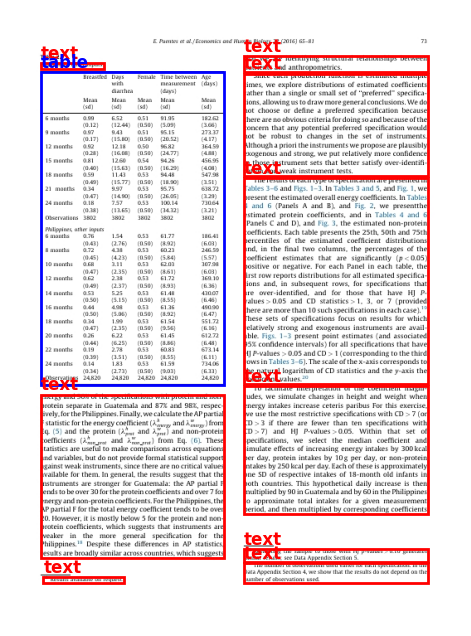

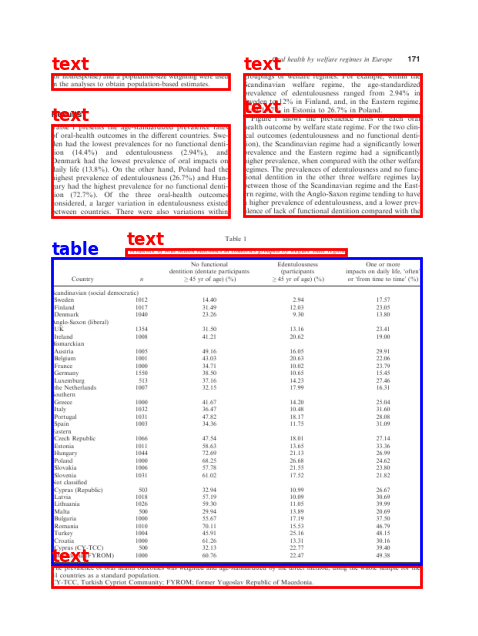

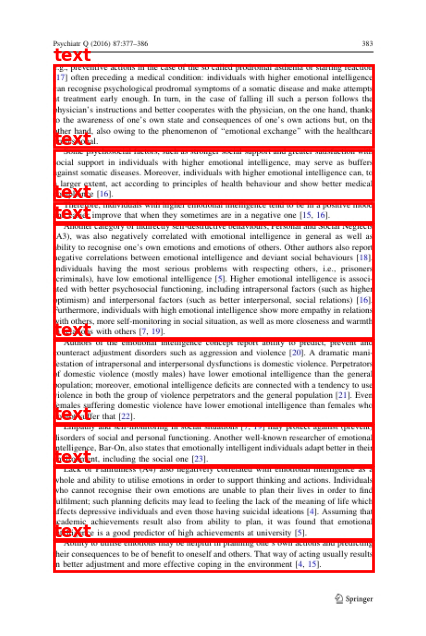

In [3]:
# Function to display an image with bounding boxes
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

random_sample = random.sample(list(filtered_annotations.keys()), 3)

def display_image_with_boxes(image_path, annotations):
    # Open the image
    img = Image.open(image_path).convert("RGB")
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    # Add bounding boxes to the image
    for ann in annotations:
        xmin, ymin, width, height = ann['bbox']
        xmax = xmin + width
        ymax = ymin + height
        label = ann['category_id']

        # Define colors for different categories
        colors = {1: 'red', 2: 'blue', 3: 'green'}
        category_names = {1: 'text', 2: 'table', 3: 'image'}

        # Draw the bounding box
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor=colors[label], facecolor='none')
        ax.add_patch(rect)

        # Add label
        plt.text(xmin, ymin - 5, category_names[label], color=colors[label], fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Display the images with bounding boxes
for image_id in random_sample:
    image_path = os.path.join(image_dir, filtered_annotations[image_id]['file_name'])
    annotations = filtered_annotations[image_id]['annotations']
    display_image_with_boxes(image_path, annotations)

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import os

# Define the custom COCO dataset class for PyTorch
class COCODataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_id = list(self.annotations.keys())[idx]
        img_path = os.path.join(self.image_dir, self.annotations[image_id]['file_name'])

        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")

        img = Image.open(img_path).convert("RGB")
        
        # Get bounding boxes and labels
        boxes = []
        labels = []
        for ann in self.annotations[image_id]['annotations']:
            xmin, ymin, width, height = ann['bbox']
            if width > 0 and height > 0:
                xmax = xmin + width
                ymax = ymin + height
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(ann['category_id'])

        # Handle cases where there are no valid boxes
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            img = self.transform(img)

        return img, target


In [5]:
dataset = COCODataset(image_dir=image_dir, annotations=filtered_annotations, transform=ToTensor())

# Split the dataset into training and validation sets (80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Prepare DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Training samples: 6400, Validation samples: 1600


In [6]:
import torch
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm  # For progress bar
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import os

# Load the pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

# Adjust the number of classes (3 classes + 1 background)
num_classes = 4  # ['background', 'text', 'table', 'image']
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the saved model weights (if available)
model_path = '/kaggle/input/ie643-fastercnn/best_model.pth'  # Replace with your model path
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
    print("Loaded pre-trained model successfully.")

# Move the model to the appropriate device (GPU/CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 224MB/s]
/tmp/ipykernel_23/2227273192.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.co

Loaded pre-trained model successfully.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Store metrics for plotting
train_losses = []
val_losses = []
map_scores = []
f1_scores = []

# Best score initialization
best_val_loss = float('inf')
best_map_score = 0.0
best_f1_score = 0.0
best_model_path = "best_model.pth"

# Calculate F1 score based on IoU threshold
def calculate_f1_score(predictions, targets, iou_threshold=0.5):
    total_true_positives = 0
    total_false_positives = 0
    total_false_negatives = 0

    for prediction, target in zip(predictions, targets):
        pred_boxes = prediction['boxes']
        gt_boxes = target['boxes']

        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue

        iou_matrix = box_iou(pred_boxes, gt_boxes)
        true_positives = (iou_matrix > iou_threshold).sum().item()
        false_positives = len(pred_boxes) - true_positives
        false_negatives = len(gt_boxes) - true_positives

        total_true_positives += true_positives
        total_false_positives += false_positives
        total_false_negatives += false_negatives

    if total_true_positives == 0:
        return 0.0

    precision = total_true_positives / (total_true_positives + total_false_positives)
    recall = total_true_positives / (total_true_positives + total_false_negatives)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1_score

# Calculate mAP score
def calculate_map_score(predictions, targets, iou_thresholds=[0.5]):
    ap_values = []

    for iou_threshold in iou_thresholds:
        total_true_positives = 0
        total_false_positives = 0
        total_false_negatives = 0

        for prediction, target in zip(predictions, targets):
            pred_boxes = prediction['boxes']
            gt_boxes = target['boxes']

            if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                continue

            iou_matrix = box_iou(pred_boxes, gt_boxes)
            true_positives = (iou_matrix > iou_threshold).sum().item()
            false_positives = len(pred_boxes) - true_positives
            false_negatives = len(gt_boxes) - true_positives

            total_true_positives += true_positives
            total_false_positives += false_positives
            total_false_negatives += false_negatives

        precision = total_true_positives / (total_true_positives + total_false_positives) if (total_true_positives + total_false_positives) > 0 else 0
        recall = total_true_positives / (total_true_positives + total_false_negatives) if (total_true_positives + total_false_negatives) > 0 else 0
        ap = precision * recall  # Simplified AP calculation
        ap_values.append(ap)

    map_score = sum(ap_values) / len(ap_values)
    return map_score

# Validation function
def validate(model, val_loader, device):
    model.eval()
    val_loss = 0
    total_f1_score = 0
    total_map_score = 0
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validation", leave=False):
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Get predictions
            predictions = model(images)

            # Calculate validation loss
            model.train()  # Temporarily switch to train mode for loss calculation
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            model.eval()  # Switch back to eval mode

            # Calculate F1 score and mAP
            total_f1_score += calculate_f1_score(predictions, targets)
            total_map_score += calculate_map_score(predictions, targets)

    avg_val_loss = val_loss / len(val_loader)
    avg_f1_score = total_f1_score / len(val_loader)
    avg_map_score = total_map_score / len(val_loader)

    return avg_val_loss, avg_f1_score, avg_map_score



Epoch 1/40, Training Loss: 0.1100, Validation Loss: 0.1085, F1 Score: 0.8158, mAP: 0.7066
Best model saved based on validation loss: 0.1085
Best model saved based on F1 score: 0.8158
Best model saved based on mAP: 0.7066


Epoch 2/40, Training Loss: 0.1009, Validation Loss: 0.1047, F1 Score: 0.8798, mAP: 0.7995
Best model saved based on validation loss: 0.1047
Best model saved based on F1 score: 0.8798
Best model saved based on mAP: 0.7995


Epoch 3/40, Training Loss: 0.0976, Validation Loss: 0.1068, F1 Score: 0.9001, mAP: 0.8299
Best model saved based on F1 score: 0.9001
Best model saved based on mAP: 0.8299


Epoch 4/40, Training Loss: 0.0944, Validation Loss: 0.1086, F1 Score: 0.8975, mAP: 0.8257


Epoch 5/40, Training Loss: 0.0928, Validation Loss: 0.1052, F1 Score: 0.8986, mAP: 0.8272


Epoch 6/40, Training Loss: 0.0906, Validation Loss: 0.1089, F1 Score: 0.9209, mAP: 0.8626
Best model saved based on F1 score: 0.9209
Best model saved based on mAP: 0.8626


Epoch 7/40, Training Loss: 0.0894, Validation Loss: 0.1093, F1 Score: 0.9012, mAP: 0.8353


Epoch 8/40, Training Loss: 0.0880, Validation Loss: 0.1094, F1 Score: 0.9210, mAP: 0.8643
Best model saved based on F1 score: 0.9210
Best model saved based on mAP: 0.8643


Epoch 9/40, Training Loss: 0.0868, Validation Loss: 0.1076, F1 Score: 0.8893, mAP: 0.8136


Epoch 10/40, Training Loss: 0.0856, Validation Loss: 0.1112, F1 Score: 0.9191, mAP: 0.8602


Epoch 11/40, Training Loss: 0.0850, Validation Loss: 0.1116, F1 Score: 0.8980, mAP: 0.8259


Epoch 12/40, Training Loss: 0.0836, Validation Loss: 0.1132, F1 Score: 0.9265, mAP: 0.8718
Best model saved based on F1 score: 0.9265
Best model saved based on mAP: 0.8718


Epoch 13/40, Training Loss: 0.0827, Validation Loss: 0.1092, F1 Score: 0.9084, mAP: 0.8434


Epoch 14/40, Training Loss: 0.0823, Validation Loss: 0.1125, F1 Score: 0.9296, mAP: 0.8781
Best model saved based on F1 score: 0.9296
Best model saved based on mAP: 0.8781


Epoch 15/40, Training Loss: 0.0813, Validation Loss: 0.1125, F1 Score: 0.9219, mAP: 0.8646


Epoch 16/40, Training Loss: 0.0805, Validation Loss: 0.1141, F1 Score: 0.9253, mAP: 0.8704


Epoch 17/40, Training Loss: 0.0803, Validation Loss: 0.1163, F1 Score: 0.9290, mAP: 0.8761


Epoch 18/40, Training Loss: 0.0798, Validation Loss: 0.1156, F1 Score: 0.9264, mAP: 0.8711


Epoch 19/40, Training Loss: 0.0781, Validation Loss: 0.1139, F1 Score: 0.9147, mAP: 0.8534


Epoch 20/40, Training Loss: 0.0782, Validation Loss: 0.1187, F1 Score: 0.9250, mAP: 0.8686


Epoch 21/40, Training Loss: 0.0772, Validation Loss: 0.1159, F1 Score: 0.9260, mAP: 0.8711


Epoch 22/40, Training Loss: 0.0766, Validation Loss: 0.1179, F1 Score: 0.9372, mAP: 0.8896
Best model saved based on F1 score: 0.9372
Best model saved based on mAP: 0.8896


Epoch 23/40, Training Loss: 0.0764, Validation Loss: 0.1181, F1 Score: 0.9234, mAP: 0.8713


Epoch 24/40, Training Loss: 0.0754, Validation Loss: 0.1202, F1 Score: 0.9339, mAP: 0.8848


Epoch 25/40, Training Loss: 0.0748, Validation Loss: 0.1239, F1 Score: 0.9390, mAP: 0.8930
Best model saved based on F1 score: 0.9390
Best model saved based on mAP: 0.8930


Epoch 26/40, Training Loss: 0.0750, Validation Loss: 0.1175, F1 Score: 0.9285, mAP: 0.8755


Epoch 27/40, Training Loss: 0.0737, Validation Loss: 0.1238, F1 Score: 0.9335, mAP: 0.8837


Epoch 28/40, Training Loss: 0.0741, Validation Loss: 0.1248, F1 Score: 0.9330, mAP: 0.8831


Epoch 29/40, Training Loss: 0.0736, Validation Loss: 0.1222, F1 Score: 0.9177, mAP: 0.8584


Epoch 30/40, Training Loss: 0.0727, Validation Loss: 0.1214, F1 Score: 0.9126, mAP: 0.8491


Epoch 31/40, Training Loss: 0.0732, Validation Loss: 0.1258, F1 Score: 0.9198, mAP: 0.8601


Epoch 32/40, Training Loss: 0.0727, Validation Loss: 0.1310, F1 Score: 0.9370, mAP: 0.8890


Epoch 33/40, Training Loss: 0.0719, Validation Loss: 0.1202, F1 Score: 0.9179, mAP: 0.8575


Epoch 34/40, Training Loss: 0.0718, Validation Loss: 0.1245, F1 Score: 0.9241, mAP: 0.8672


Epoch 35/40, Training Loss: 0.0714, Validation Loss: 0.1267, F1 Score: 0.9336, mAP: 0.8833


Epoch 36/40, Training Loss: 0.0710, Validation Loss: 0.1263, F1 Score: 0.9254, mAP: 0.8705


Epoch 37/40, Training Loss: 0.0699, Validation Loss: 0.1230, F1 Score: 0.9010, mAP: 0.8296


Epoch 38/40, Training Loss: 0.0709, Validation Loss: 0.1281, F1 Score: 0.9400, mAP: 0.8948
Best model saved based on F1 score: 0.9400
Best model saved based on mAP: 0.8948


Epoch 39/40, Training Loss: 0.0692, Validation Loss: 0.1323, F1 Score: 0.9420, mAP: 0.8979
Best model saved based on F1 score: 0.9420
Best model saved based on mAP: 0.8979


Epoch 40/40, Training Loss: 0.0690, Validation Loss: 0.1309, F1 Score: 0.9404, mAP: 0.8953


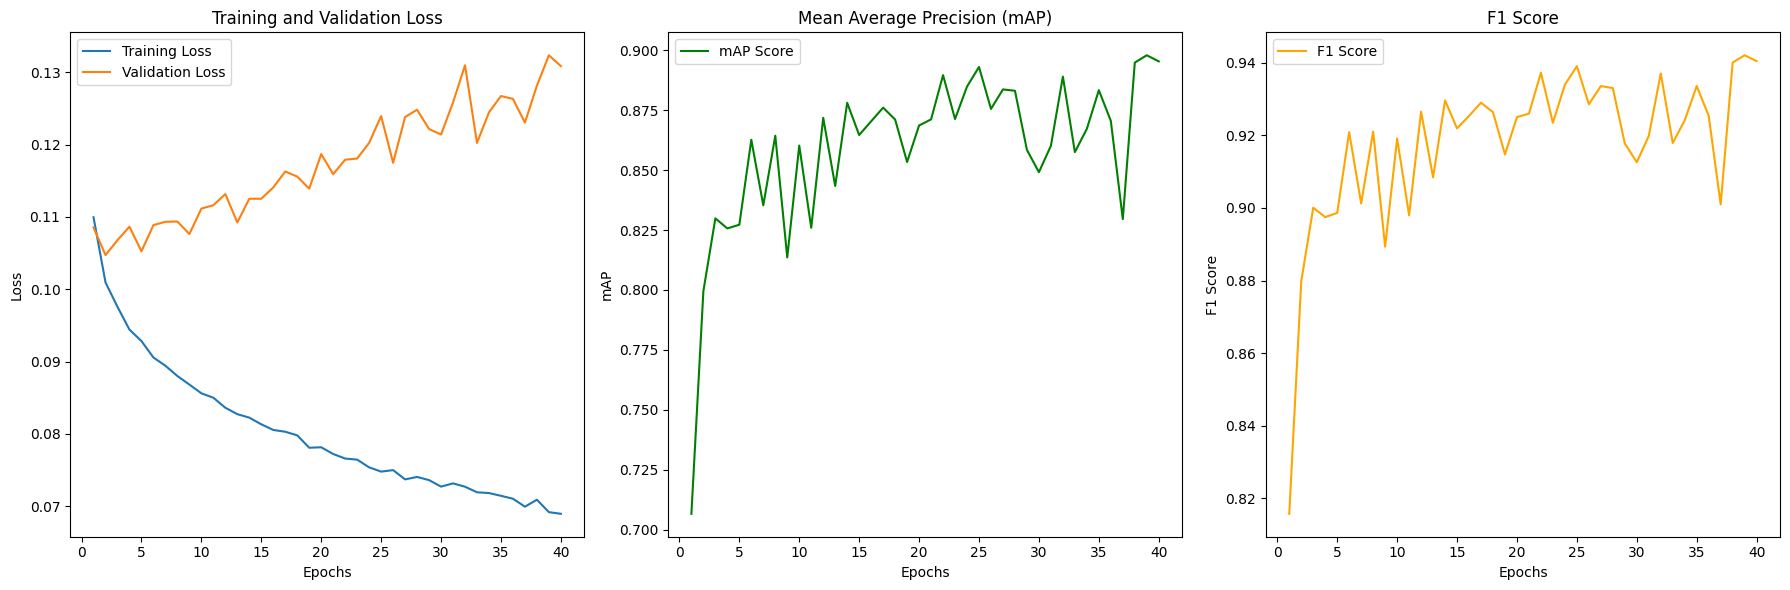

In [8]:
# Training loop
num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    train_loader = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}", leave=False)

    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    avg_val_loss, avg_f1_score, avg_map_score = validate(model, val_loader, device)
    val_losses.append(avg_val_loss)
    f1_scores.append(avg_f1_score)
    map_scores.append(avg_map_score)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, F1 Score: {avg_f1_score:.4f}, mAP: {avg_map_score:.4f}")

    # Save the best model based on validation loss, F1 score, or mAP
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved based on validation loss: {best_val_loss:.4f}")

    if avg_f1_score > best_f1_score:
        best_f1_score = avg_f1_score
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved based on F1 score: {best_f1_score:.4f}")

    if avg_map_score > best_map_score:
        best_map_score = avg_map_score
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved based on mAP: {best_map_score:.4f}")

# Plotting the metrics
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Plot mAP scores
plt.subplot(1, 3, 2)
plt.plot(epochs_range, map_scores, label='mAP Score', color='green')
plt.xlabel('Epochs')
plt.ylabel('mAP')
plt.legend()
plt.title('Mean Average Precision (mAP)')

# Plot F1 scores
plt.subplot(1, 3, 3)
plt.plot(epochs_range, f1_scores, label='F1 Score', color='orange')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score')

plt.tight_layout()
plt.show()